# **Image Classification with Lightning Flash and Kornia**

*author* - Edgar Riba [ [edgarriba](https://github.com/edgarriba) ]


In this example we are going to learn how to combine [Flash](https://lightning-flash.readthedocs.io/en/latest/) and [Kornia](www.kornia.org) augmentations in the GPU to solve in an efficient way an image classification problem.

### **Motivation**
Traditionally, the data augmentation process has been attached to the `DataLoader` where each worker is the responsible of loading each image sample, decoding, and the associated labels.

Eventually, this can be the bottleneck in you training pipeline when you work with high resolution images, or for instance you have a distributed setting, or even if you want to make use of HPC devices to speed up your pipeline.

However, not in every scenario you want use all your resources to perform the augmentations but instead find a balance between the preprocessing of the data while you maintain the performance during the training of your model.

### **Proposal**

For this reason, in [Flash](https://lightning-flash.readthedocs.io/en/latest/) we have introduced an API which any user can find this balance when to define the preprocessing and augmentations pipelines so that you can make your training process more efficient depending on your HPC configuration.

In particular, in this tutorial will walk through the new API for the `DataModule` to define the augmentations in each stage of the preproces. We will also show how to use [Kornia](www.kornia.org) augmentations which in composition with the new API, we enable the users to easily design efficient data augmentation pipelines in the GPU (or TPU).

# Install the libraries

We first install the needed libraries in its latest version. Kornia for the data augmentation and Flash as the engine to perform the trainig.

In [ ]:
# Only for TPU
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

In [ ]:
!pip install -q kornia
!pip install -q -U Pillow
!pip install -q git+https://github.com/PytorchLightning/pytorch-lightning.git@master
!pip install -q git+https://github.com/PytorchLightning/lightning-flash.git@master

     |████████████████████████████████| 276kB 17.7MB/s 
     |████████████████████████████████| 3.0MB 18.0MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 276kB 20.5MB/s 
     |████████████████████████████████| 184kB 50.7MB/s 
     |████████████████████████████████| 829kB 59.2MB/s 
     |████████████████████████████████| 112kB 53.2MB/s 
     |████████████████████████████████| 1.3MB 53.9MB/s 
     |████████████████████████████████| 143kB 58.7MB/s 
     |████████████████████████████████| 296kB 52.9MB/s 
     |████████████████████████████████| 256kB 19.8MB/s 
     |████████████████████████████████| 2.1MB 43.3MB/s 
     |████████████████████████████████| 163kB 43.5MB/s 
     |████████████████████████████████| 22.3MB 109kB/s 
     |█████████████████████

## Sanity check of the libraries versions

In [ ]:
import kornia as K
print(K.__version__)

import pytorch_lightning as pl
print(pl.__version__)

import flash
print(flash.__version__)

0.5.0
1.3.0rc1
0.3.0dev


# Import the needed libraries and components

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# import our libraries
import torch
import kornia as K
import numpy as np
from PIL import Image

import flash
from flash.data.utils import download_data
from flash.vision import ImageClassificationData, ImageClassifier

/usr/local/lib/python3.7/dist-packages/pl_bolts/utils/warnings.py:32: UserWarning: You want to use `wandb` which is not installed yet, install it with `pip install wandb`.
  f' install it with `pip install {pypi_name}`.' + extra_text


# Download the dataset

We first download the dataset that we will use for training and store in our local directory `data/`.

This dataset is composed by images of insects and an associated class name per each image.

In [ ]:
download_data("https://pl-flash-data.s3.amazonaws.com/hymenoptera_data.zip", 'data/')

# Create a Datamodule with Lightning-flash

We use Flash `ImageClassificationData.from_folders` in order to read the dataset by specifying the directories contaiing the data for training, validation and testing.

Notice that we specify the `batch_size` in order to visualise later several sample at once. Play a bit with this value :)

In [ ]:
datamodule = ImageClassificationData.from_folders(
    train_folder="data/hymenoptera_data/train/",
    val_folder="data/hymenoptera_data/val/",
    test_folder="data/hymenoptera_data/test/",
    batch_size=8,
)

# Visualise the image data

The first thing that you might want to do is understand the nature of the problem and how your images look like and which labels have associated at loading time.

In the code below, we have implemented a naive visualiser using `matplotlib` that shows a grid of images and the label associated to it that the training datatloader provides to you before passing the data to the `Trainer`.

Notice that by default, Flash applies `RandomResizedCrop((196,196))` and `RandomHorizontalFlip`.

In [ ]:
def show_batch(dm: ImageClassificationData):
    # fetch data from the training data loader
    img, label = next(iter(dm.train_dataloader()))

    cols: int = 4
    rows: int = img.shape[0] // cols

    fig, axs = plt.subplots(rows, cols)
    fig.suptitle('Before forward')

    for i, ax in enumerate(axs.ravel()):
        _img, _label = img[i], label[i]
        ax.imshow(K.tensor_to_image(_img))
        ax.set_title(_label)
        ax.axis('off')
    plt.show() 

### **Click RUN**

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data 

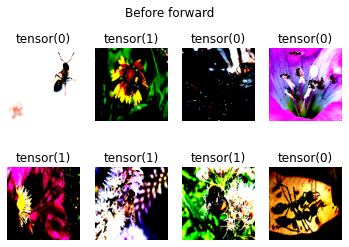

In [ ]:
show_batch(datamodule)

# Visualize the labels distribution

The next thing you might want to do in a classification problem is to visualisation how are your labels distributed across the different classes.

*TIP*: This might help you to decided whether to use a resampling technique. See [`torchsampler`](https://github.com/ufoym/imbalanced-dataset-sampler)

   bees  ants
0   121   124


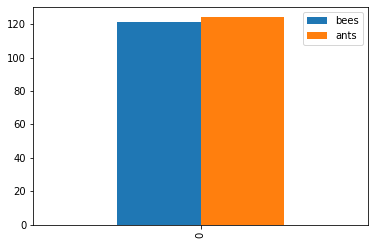

In [ ]:
from typing import Dict, List
import os
import pandas as pd

DATA_ROOT: str = datamodule.train_dataset.data

classes: List[str] = os.listdir(DATA_ROOT)

labels_dist: Dict[str, int] = {}

for class_name in classes:
    class_files: List[str] = os.listdir(os.path.join(DATA_ROOT, class_name))
    labels_dist[class_name] = [len(class_files)]

train_df = pd.DataFrame(labels_dist)
print(train_df.head())

train_df.plot(kind="bar")

# Visualise and Design the augmentations

This one of the crucial moments in every Machine Learning and Deep Learning process where you have to decide (if needed) which data augmentations techniques or strategies you migh want to choose for you problem.

In the section below, we make use of the new Flash API and [`kornia.augmentation`](https://kornia.readthedocs.io/en/latest/augmentation.html) in order to define an hybrid approach for the preprocessing and augmentations pipeline.

Notice that we have defined `Preprocess` and `Augmentation` classed that subclass `torch.nn.Module` so that everything can be in accordance with the Pytorch computational graph and take advantage of the optimisation provided by the `torch.Tensor`.

In [ ]:
 import torch
 import torch.nn as nn
 import kornia as K
 
 # Define the augmentations pipeline

DATA_MEAN = [0.485, 0.456, 0.406]
DATA_STD = [0.229, 0.224, 0.225]

class Resize(nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.size = size
    
    def forward(self, x):
        return K.geometry.resize(x[None], self.size)[0]

class Preprocess(nn.Module):
    """Applies the processing to the image in the worker before collate."""
    def __init__(self):
        super().__init__()
        self.preprocess = nn.Sequential(
            #K.augmentation.RandomResizedCrop((224, 224)),
            Resize((120, 120)),  # use this better to see whole image
            K.augmentation.Normalize(
                torch.tensor(DATA_MEAN),
                torch.tensor(DATA_STD),
            ),
        )
    @torch.no_grad()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert len(x.shape) == 3, x.shape
        return self.preprocess(x)

class Augmentation(nn.Module):
    """Applies random augmentation to a batch of images."""
    def __init__(self, viz: bool = False):
        super().__init__()
        self.viz = viz
        self.geometric = [
            K.augmentation.RandomAffine(60., p=0.75),
            K.augmentation.RandomPerspective(0.4, p=0.5),       
        ]
        self.augmentations = nn.Sequential(
            K.augmentation.GaussianBlur((3, 3), (0.1, 2.0), p=1.0),
            K.augmentation.ColorJitter(0.01, 0.01, 0.01, 0.01, p=0.25),
            K.augmentation.RandomHorizontalFlip(p=0.75),
            K.augmentation.RandomVerticalFlip(p=0.75),
        )
        self.denorm = K.augmentation.Denormalize(
            torch.tensor(DATA_MEAN),
            torch.tensor(DATA_STD),
        )

    @torch.no_grad()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert len(x.shape) == 4, x.shape
        idx = torch.randperm(len(self.geometric))[0]  # OneOf
        out = self.geometric[idx](x)
        out = self.augmentations(out)
        if self.viz:
            out = self.denorm(out)
        return out

Once with our preprocessing and augmentations pipeline, you will notice how simple is in Flash to define where and when we want those transorms to happen.

In our new API you just need to pass a dictionary with the corresponding keys and operators, and then just provide it to the `ImageClassificationData` data module.

In our case we are interested in `post_tensor_transform` that will be called inside each of the DataLoader worker after the image sample is casted to a `torch.Tensor`. In order to make happen the random transformations in batch mode we need to populate the key `per_batch_transform`.

In [ ]:
from typing import Callable

TRAIN_TRANSFORMS: Dict[str, Callable] = {
    "post_tensor_transform": Preprocess(),
    "per_batch_transform": Augmentation(viz=True),
    # Use the one below when you want to train and perform the
    # the data augmentation on device (GPU/TPU).
    #"per_batch_transform_on_device": Augmentation(viz=False),
}

# 2. Load the data
datamodule = ImageClassificationData.from_folders(
    train_folder="data/hymenoptera_data/train/",
    val_folder="data/hymenoptera_data/val/",
    test_folder="data/hymenoptera_data/test/",
    batch_size=8,
    train_transform=TRAIN_TRANSFORMS
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


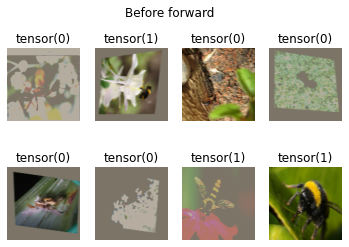

In [ ]:
show_batch(datamodule)

In [ ]:
# 3. Build the model
model = ImageClassifier(num_classes=datamodule.num_classes, backbone="resnet18")

# 4. Create the trainer. Run once on data
trainer = flash.Trainer(max_epochs=10, gpus=1)

# 5. Finetune the model
trainer.finetune(model, datamodule=datamodule, strategy="freeze")

# 6. Save it!
trainer.save_checkpoint("image_classification_model.pt")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                          | Params
---------------------------------------------------------------
0 | metrics      | ModuleDict                    | 0     
1 | _postprocess | ClassificationPostprocess     | 0     
2 | backbone     | Sequential                    | 11.2 M
3 | head         | Sequential                    | 1.0 K 
4 | _preprocess  | ImageClassificationPreprocess | 0     
---------------------------------------------------------------
10.6 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
